### Installs, Imports, and Pyro Setup 

In [1]:
# 1# Run first time
! module load cuda/9.2.88-gcc/7.1.0 cudnn/7.6.5.32-9.2-linux-x64-gcc/7.1.0-cuda9_2 anaconda3/2019.10-gcc/8.3.1
! source activate pytorch_env
# !pip install --up
# !pip install pyro-ppl
# !pip install torchvision
# !pip install --upgrade git+https://github.com/dhudsmith/clean-the-text
# !pip install umap-learn

In [2]:
import os
import pickle as pkl
from typing import List

import numpy as np
import torch
import graphviz
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import pandas as pd

from ctt.clean import kitchen_sink

import pyro
from pyro import poutine
import pyro.distributions as dist
# import pyro.contrib.examples.util  # patches torchvision
from pyro.infer import SVI, Trace_ELBO, TraceMeanField_ELBO
from pyro.optim import Adam, ClippedAdam
import torch.nn.functional as F
from scipy.io import loadmat

import scipy
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.datasets import fetch_20newsgroups
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
import pandas as pd
import matplotlib.pyplot as plt
import wandb
import umap
import umap.plot
import sklearn.datasets

plt.rcParams["figure.figsize"] = (10,5)

In [3]:
pyro.distributions.enable_validation(True)

In [4]:
pyro.set_rng_seed(0)

# Setup

In [5]:
# Data
NUMBER_PAIRS = 100000
VAL_RATIO = 0.1
TEST_RATIO = 0.2
MIN_NUM_TOKS = 2
NUM_WORKERS = 0

# Dropout rate
NUM_TOPICS = 50
NUM_PROTOTYPES = 7
EMBED_DIM  = 64
HIDDEN_DIM = 128
DROPOUT_RATE = 0.2

# Training
adam_args = {"lr": 0.001, 'clip_norm':10.0, 'betas': (0.99, 0.999)}
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
NUM_EPOCHS = 10
TEST_FREQUENCY = 1
BATCH_SIZE = 128
VAL_BATCH_SIZE = 2000
OBS_SAMPLES = 10

# Initialize W & B

In [6]:
run = wandb.init(project="prodLDA_pairs", entity="witw", )
wandb.run.name = "prototype_vectors" 

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: witw (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.14 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade

CondaEnvException: Unable to determine environment

Please re-run this command with one of the following options:

* Provide an environment name via --name or -n
* Re-run this command inside an activated conda environment.



# Data Prep

In [7]:
newsgroups_train = fetch_20newsgroups(subset='all', remove=('headers','footers','quotes'))

In [8]:
names_dict = {i:v.split('.')[0] for i,v in enumerate(newsgroups_train['target_names'])}

In [9]:
df = pd.DataFrame({'text': newsgroups_train['data'], 'category': newsgroups_train['target']})
df['category'] = df['category'].apply(lambda x: names_dict[x])
df['text'] = df['text'].apply(lambda x: kitchen_sink(x))

In [10]:
# split into train/val/test
train, test = train_test_split(df, test_size = VAL_RATIO + TEST_RATIO)
test, val = train_test_split(test, test_size = VAL_RATIO/(VAL_RATIO + TEST_RATIO))  

In [11]:
val

,text,category
971,+ + | kevin marshall operational support motor...,comp
3832,request goes medical students done planning si...,sci
4476,really stupid nitpicking capitalization rules ...,talk
17368,matter assume obeying law since court order ta...,sci
7126,principles admit someone else might everyone a...,talk
...,...,...
756,checked faq first luck need convert r5 tree wi...,comp
4003,referring mary quite problem idea mary never c...,soc
2763,interesting sometimes listen news seen eyes an...,talk
1743,b b,rec


In [12]:
# create and train vectorizer
vectorizer = CountVectorizer(min_df=20, max_df=0.7)
vectorizer = vectorizer.fit(train['text'].astype(str))

# set vocab size now that we know it
VOCAB_SIZE = len(vectorizer.vocabulary_)

In [13]:
# get bow vectors
bows = vectorizer.transform(df.iloc[:,0].astype(str)).astype(np.int16)

In [14]:
# get bow for datasets
bows_train, bows_val, bows_test = [
    vectorizer.transform(d.iloc[:,0].astype(str)).astype(np.int16)
    for d in [train, val, test]
]

In [15]:
# find document indices where number of tokens is >=min_num_toks
ix_keep_train, ix_keep_val, ix_keep_test = [
    np.argwhere(np.asarray(bow.sum(axis=-1)).squeeze() >= MIN_NUM_TOKS).squeeze()
    for bow in [bows_train, bows_val, bows_test]
]

In [16]:
# subset bows to these indices
# NOTE: these are not currently used
bows_train = bows_train[ix_keep_train]
bows_val = bows_train[ix_keep_val]
bows_test = bows_train[ix_keep_test]

# subset dfs for later lookups
train = train.iloc[ix_keep_train]
val = train.iloc[ix_keep_val]
test = train.iloc[ix_keep_test]

In [17]:
# make sure our subsetting worked correctly
print("(num_samples, vocab_size) (num_samples, num_columns) min_num_toks")
print("Train:", bows_train.shape, train.shape, bows_train.sum(axis=-1).min())
print("Val:", bows_val.shape, val.shape, bows_val.sum(axis=-1).min())
print("Test:", bows_test.shape, test.shape, bows_test.sum(axis=-1).min())

(num_samples, vocab_size) (num_samples, num_columns) min_num_toks
Train: (12680, 6373) (12680, 2) 2
Val: (1806, 6373) (1806, 2) 2
Test: (3628, 6373) (3628, 2) 2


In [18]:
def get_pairs_table(df):
    pair_ix = np.random.choice(df.index.values, size=(NUMBER_PAIRS,2), replace=True)
    catsA = df.category[pair_ix[:,0]]
    catsB = df.category[pair_ix[:,1]]

    top_cat_A = catsA.str.split('.').apply(lambda x: x[0])
    top_cat_B = catsB.str.split('.').apply(lambda x: x[0])

    is_similar = (top_cat_A.values == top_cat_B.values)

    return pd.DataFrame({'ix_A': pair_ix[:,0],
                         'ix_B': pair_ix[:,1],
                         'label': is_similar})

train_pairs, val_pairs, test_pairs = [
                                      get_pairs_table(d)
                                      for d in [train, val, test]
]

# Custom Dataloader/Dataset

In [19]:
class DocumentPairData(Dataset):

    def __init__(self, bows, index_table, prob=0.5):
        """
        Integrated dataset loader (supervised and unsupervised dataset)
        
        Args:
            data: an pre-loaded sparse matrix
            index_table: dataframe/list of pre-split pairwise indices, where index_table[i] = [a_ix, b_ix, label]
            prob (float): between [0,1], the probability of returning a supervised sample

        Return:
            {'a': bow, 'b': bow, 'label': bool, observed: bool}
        """
        self.bows = bows
        self.index_table = index_table
        self.prob = prob
            
    def __len__(self):
        return len(self.index_table)

    def __getitem__(self, ix): 
        
        a_ix = self.index_table.iloc[ix][0]
        b_ix = self.index_table.iloc[ix][1]
        label = self.index_table.iloc[ix][2]
                
        a = self.bows[a_ix].toarray().astype(np.float32)
        b = self.bows[b_ix].toarray().astype(np.float32)
        
        is_observed = (np.random.rand() < self.prob)
        
        return {'a': a, 'b': b, 'label': label, 'observed': is_observed}

In [20]:
# datasets
data_train, data_val, data_test = [
    DocumentPairData(bows=bows, index_table=ix_table, prob=0.5)
    for ix_table in [train_pairs, val_pairs, test_pairs]
]

# dataloaders
dl_train = DataLoader(data_train, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True)
dl_val = DataLoader(data_val, batch_size=VAL_BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=False)
dl_test = DataLoader(data_test, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=False)

In [21]:
for k, v in next(iter(dl_train)).items():
    print(k,":", v.shape, v.dtype)

a : torch.Size([128, 1, 6373]) torch.float32
b : torch.Size([128, 1, 6373]) torch.float32
label : torch.Size([128]) torch.bool
observed : torch.Size([128]) torch.bool


# ETM Modelling 

In [22]:
class Encoder(nn.Module):
    # Base class for the encoder net, used in the guide
    def __init__(self, vocab_size, num_topics, hidden, dropout):
        super().__init__()
        self.drop = nn.Dropout(dropout)  # to avoid component collapse
        self.fc1 = nn.Linear(vocab_size, hidden)
        self.fc2 = nn.Linear(hidden, hidden)
        self.fcmu = nn.Linear(hidden, num_topics)
        self.fclv = nn.Linear(hidden, num_topics)
        # NB: here we set `affine=False` to reduce the number of learning parameters
        # See https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html
        # for the effect of this flag in BatchNorm1d
        self.bnmu = nn.BatchNorm1d(num_topics, affine=False)  # to avoid component collapse
        self.bnlv = nn.BatchNorm1d(num_topics, affine=False)  # to avoid component collapse

    def forward(self, inputs):
        h = F.softplus(self.fc1(inputs))
        h = F.softplus(self.fc2(h))
        h = self.drop(h)
        # μ and Σ are the outputs
        logtheta_loc = self.bnmu(self.fcmu(h))
        logtheta_logvar = self.bnlv(self.fclv(h))
        logtheta_scale = (0.5 * logtheta_logvar).exp()  # Enforces positivity
        return logtheta_loc, logtheta_scale+0.0001

In [23]:
class Decoder(nn.Module):
    # Base class for the decoder net, used in the model
    def __init__(self, vocab_size, num_topics, dropout):
        super().__init__()
        self.beta = nn.Linear(num_topics, vocab_size, bias=False)
        self.bn = nn.BatchNorm1d(vocab_size, affine=False)
        self.drop = nn.Dropout(dropout)

    def forward(self, inputs):
        inputs = self.drop(inputs)
        # the output is σ(βθ)
        return F.softmax(self.bn(self.beta(inputs)), dim=1)

In [24]:
class ProdLDA(nn.Module):
    def __init__(self, vocab_size, num_topics, hidden, dropout):
        super().__init__()
        self.vocab_size = vocab_size
        self.num_topics = num_topics
        self.encoder = Encoder(vocab_size, num_topics, hidden, dropout).to(DEVICE)
        self.decoder = Decoder(vocab_size, num_topics, dropout).to(DEVICE)

    def model(self, docs_a, docs_b, c, x=None):
        pyro.module("decoder", self.decoder)
        with pyro.plate("documents_a", docs_a.shape[0]):
            # Dirichlet prior 𝑝(𝜃|𝛼) is replaced by a logistic-normal distribution
            logtheta_loc_a = docs_a.new_zeros((docs_a.shape[0], self.num_topics))
            logtheta_scale_a = docs_a.new_ones((docs_a.shape[0], self.num_topics))
            logtheta_a = pyro.sample(
                "logtheta_a", dist.Normal(logtheta_loc_a, logtheta_scale_a).to_event(1))
            theta_a = F.softmax(logtheta_a, -1)

            # conditional distribution of 𝑤𝑛 is defined as
            # 𝑤𝑛|𝛽,𝜃 ~ Categorical(𝜎(𝛽𝜃))
            count_param_a = self.decoder(theta_a)
            # Currently, PyTorch Multinomial requires `total_count` to be homogeneous.
            # Because the numbers of words across documents can vary,
            # we will use the maximum count accross documents here.
            # This does not affect the result because Multinomial.log_prob does
            # not require `total_count` to evaluate the log probability.
            total_count_a = int(docs_a.sum(-1).max())
            pyro.sample(
                'obs_a',
                dist.Multinomial(total_count_a, count_param_a),
                obs=docs_a
            )
        with pyro.plate("documents_b", docs_b.shape[0]):
            # Dirichlet prior 𝑝(𝜃|𝛼) is replaced by a logistic-normal distribution
            logtheta_loc_b = docs_b.new_zeros((docs_b.shape[0], self.num_topics))
            logtheta_scale_b = docs_b.new_ones((docs_b.shape[0], self.num_topics))
            logtheta_b = pyro.sample(
                "logtheta_b", dist.Normal(logtheta_loc_b, logtheta_scale_b).to_event(1))
            theta_b = F.softmax(logtheta_b, -1)

            # conditional distribution of 𝑤𝑛 is defined as
            # 𝑤𝑛|𝛽,𝜃 ~ Categorical(𝜎(𝛽𝜃))
            count_param_b = self.decoder(theta_b)
            # Currently, PyTorch Multinomial requires `total_count` to be homogeneous.
            # Because the numbers of words across documents can vary,
            # we will use the maximum count accross documents here.
            # This does not affect the result because Multinomial.log_prob does
            # not require `total_count` to evaluate the log probability.
            total_count_b = int(docs_b.sum(-1).max())
            pyro.sample(
                'obs_b',
                dist.Multinomial(total_count_b, count_param_b),
                obs=docs_b
            )
        
        if x is not None:
            with pyro.plate('pairs', x.shape[0]):
                pyro.sample(
                        'obs_c',
                        dist.Bernoulli(logits=x),
                        obs=c
                    )

    def guide(self, docs_a, docs_b, c, x=None):
        pyro.module("encoder", self.encoder)
        with pyro.plate("documents_a", docs_a.shape[0]):
            # Dirichlet prior 𝑝(𝜃|𝛼) is replaced by a logistic-normal distribution,
            # where μ and Σ are the encoder network outputs
            logtheta_loc_a, logtheta_scale_a = self.encoder(docs_a)
            logtheta_a = pyro.sample(
                "logtheta_a", dist.Normal(logtheta_loc_a, logtheta_scale_a).to_event(1))
        with pyro.plate("documents_b", docs_b.shape[0]): 
            # Dirichlet prior 𝑝(𝜃|𝛼) is replaced by a logistic-normal distribution,
            # where μ and Σ are the encoder network outputs
            logtheta_loc_b, logtheta_scale_b = self.encoder(docs_b)
            logtheta_b = pyro.sample(
                "logtheta_b", dist.Normal(logtheta_loc_b, logtheta_scale_b).to_event(1)) 
        
        p = pyro.param('p', torch.randn(NUM_PROTOTYPES, NUM_TOPICS, device=DEVICE))
        norm = (p**2).sum(axis=-1).sqrt().unsqueeze(-1)
        p = p / norm
        
        a = pyro.param('a', torch.tensor(1.0, device=DEVICE))
        b = pyro.param('b', torch.tensor(0.0, device=DEVICE))
        
        
        sA = logtheta_loc_a @ p.t()
        sB = logtheta_loc_b @ p.t()
        x =  pyro.deterministic("x", a * (sA * sB).sum(dim=-1) + b)
        return x

    def beta(self):
        # beta matrix elements are the weights of the FC layer on the decoder
        return self.decoder.beta.weight.detach().T
    
    def calc_kl_divergence(self, x):
        # Calculate KL Divergence of latent document distributions
        z_loc, z_sigma = self.encoder(x)
        size = z_loc.shape[1]
        kl_loss = torch.sum(
            (-torch.log(z_sigma) + (torch.square(z_sigma) + torch.square(z_loc))/2 - 1/2), (0, 1))

        return kl_loss
    
    def reconstruct_doc(self, x):
        x=x.to(DEVICE).squeeze()
        
        with torch.no_grad():
            z_loc, _ = self.encoder(x)
            theta = F.softmax(z_loc, dim=-1)
            word_probs = self.decoder(theta)
                              
        return word_probs
        

### Custom ELBO

In [25]:
# this custom elbo allows us to pass deterministic values from the guide 
# into the model
def custom_elbo(model, guide, *args, **kwargs):
    # run the guide and trace its execution
    guide_trace = poutine.trace(guide).get_trace(*args, **kwargs)

    # get the 'x_loc' value from the guide trace
    x = guide_trace.nodes['x']['value']

    # run the model and replay it against the samples from the guide
    # notice where x_loc is passed into the model
    model_trace = poutine.trace(
        poutine.replay(model, trace=guide_trace)).get_trace(x = x, *args, **kwargs)
    # construct the elbo loss function
    return -1*(model_trace.log_prob_sum() - guide_trace.log_prob_sum())

# Training and Evaluation Functions 

In [26]:
def train(svi, train_loader, device, progress_interval = 100, print_debug = False):
    topic_model.train()
    
    # initialize loss accumulator
    epoch_loss = 0.
    train_acc = 0.0
    train_auroc = 0.0
    batches = 0
    
    
    # do a training epoch over each mini-batch x returned
    # by the data loader
    for i, x in enumerate(train_loader):
        batches += 1
        # if on GPU put mini-batch into CUDA memory
        x_a = x['a'].to(device).squeeze()
        x_b = x['b'].to(device).squeeze()
        x_label = x['label'].to(device).type(torch.float32)
        
        if print_debug and i % progress_interval == 0:
            print(f"Step {i}; avg. loss {epoch_loss/(i+1)}", end='\r')
        
        # do ELBO gradient and accumulate loss
        epoch_loss += svi.step(x_a, x_b, x_label)
        
        with torch.no_grad():
            x = svi.guide(x_a, x_b, x_label)

        x_label = x_label.cpu()
        logits = x.cpu()
#         # do something with the log odds
        logits_binned = np.digitize(logits, [0.5], right=False)
        train_acc += accuracy_score(x_label, logits_binned)
        train_auroc += roc_auc_score(x_label, logits)

        
    # return epoch loss
    normalizer_train = len(train_loader.dataset)
    total_epoch_loss_train = epoch_loss / normalizer_train
    epoch_acc = train_acc / batches
    epoch_auroc = train_auroc / batches
    return total_epoch_loss_train, epoch_acc, epoch_auroc

In [27]:
def evaluate(svi, etm, test_loader, device): 
    etm.eval()
    
    # initialize loss accumulator
    test_loss = 0.0
    test_ce_loss = 0.0
    test_kl_loss = 0.0
    test_acc = 0.0
    test_auroc = 0.0
    batches = 0
    
    # compute the loss over the entire test set
    for x in test_loader:
        batches += 1
        # if on GPU put mini-batch into CUDA memory
        x_a = x['a'].to(device).squeeze()
        x_b = x['b'].to(device).squeeze()
        x_label = x['label'].to(device).type(torch.float32)
            
        # compute ELBO estimate and accumulate loss
        test_loss += svi.evaluate_loss(x_a, x_b, x_label)
        
        # generate reconstruction of batch documents and move to cuda if designated
        with torch.no_grad():
            recon_x_a = etm.reconstruct_doc(x_a)
            recon_x_b = etm.reconstruct_doc(x_b)
            logits = svi.guide(x_a, x_b, x_label)

        x_label = x_label.cpu()
        logits = logits.cpu()
#         # do something with the log odds
        logits_binned = np.digitize(logits, [0.3], right=False)
        test_acc += accuracy_score(x_label, logits_binned)
        test_auroc += roc_auc_score(x_label, logits)

        # calculate and sum cross entropy loss and kl divergence
        x_a=x_a.squeeze()
        x_b=x_b.squeeze()
        log_probs_a = torch.log(recon_x_a)
        log_probs_b = torch.log(recon_x_b)
        targets_a = x_a/(x_a.sum(axis=-1)[:,None])
        targets_b = x_b/(x_b.sum(axis=-1)[:,None])
        ce_loss_a = F.cross_entropy(log_probs_a, targets_a, reduction='sum')
        ce_loss_b = F.cross_entropy(log_probs_b, targets_b, reduction='sum')
        test_ce_loss += ce_loss_a + ce_loss_b
        test_kl_loss += etm.calc_kl_divergence(x_a.squeeze(1)) + etm.calc_kl_divergence(x_b.squeeze(1))

        
    normalizer_test = len(test_loader.dataset)
    epoch_elbo = test_loss / normalizer_test
    epoch_ce_loss = test_ce_loss / normalizer_test
    epoch_kl_loss = test_kl_loss / normalizer_test
    epoch_acc = test_acc / batches
    epoch_auroc = test_auroc / batches
    
    return epoch_elbo, epoch_ce_loss.item(), epoch_kl_loss.item(), epoch_acc, epoch_auroc

## Training 

In [28]:
# clear param store
pyro.clear_param_store()

# setup the VAE
topic_model = ProdLDA(VOCAB_SIZE, NUM_TOPICS, HIDDEN_DIM, DROPOUT_RATE).to(DEVICE)

# setup the optimizer
optimizer = ClippedAdam(adam_args)

# setup the inference algorithm
svi = SVI(topic_model.model, topic_model.guide, optimizer, loss=custom_elbo)

In [29]:
batch_1 = next(iter(dl_train))
dat_a = batch_1['a'].to(DEVICE).squeeze()
dat_b = batch_1['b'].to(DEVICE).squeeze()
dat_label = batch_1['label'].to(DEVICE).squeeze().type(torch.float32)

print(pyro.poutine.trace(topic_model.model).get_trace(dat_a, dat_b, dat_label).format_shapes())

        Trace Shapes:             
         Param Sites:             
decoder$$$beta.weight 6373 50     
        Sample Sites:             
     documents_a dist       |     
                value  128  |     
      logtheta_a dist  128  |   50
                value  128  |   50
           obs_a dist  128  | 6373
                value  128  | 6373
     documents_b dist       |     
                value  128  |     
      logtheta_b dist  128  |   50
                value  128  |   50
           obs_b dist  128  | 6373
                value  128  | 6373


In [30]:
print(pyro.poutine.trace(topic_model.guide).get_trace(dat_a, dat_b, dat_label).format_shapes())

        Trace Shapes:             
         Param Sites:             
 encoder$$$fc1.weight 128 6373    
   encoder$$$fc1.bias      128    
 encoder$$$fc2.weight 128  128    
   encoder$$$fc2.bias      128    
encoder$$$fcmu.weight  50  128    
  encoder$$$fcmu.bias       50    
encoder$$$fclv.weight  50  128    
  encoder$$$fclv.bias       50    
                    p   7   50    
                    a             
                    b             
        Sample Sites:             
     documents_a dist        |    
                value 128    |    
      logtheta_a dist 128    |  50
                value 128    |  50
     documents_b dist        |    
                value 128    |    
      logtheta_b dist 128    |  50
                value 128    |  50
               x dist        | 128
                value        | 128


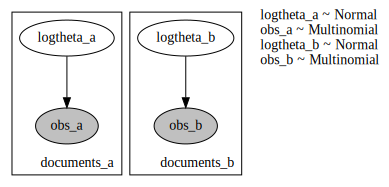

In [31]:
pyro.render_model(topic_model.model, model_args=(dat_a, dat_b, dat_label, ), render_distributions=True)

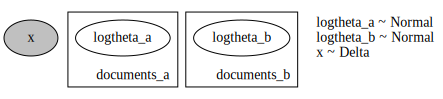

In [32]:
pyro.render_model(topic_model.guide, model_args=(dat_a, dat_b, dat_label, ), render_distributions=True)

In [33]:
x = topic_model.guide(dat_a, dat_b, dat_label)

In [34]:
# num samples 10, do auroc/accuracy for all, average results, show sd
# use scikit-learn

In [35]:
train_elbo = []
test_elbo = []
test_celoss = []
test_klloss = []
print("Beginning Training")
# training loop
for epoch in range(NUM_EPOCHS):
#     total_epoch_loss_train, train_acc, train_auroc = train(svi, dl_train, device=DEVICE, print_debug=True)
    total_epoch_loss_train, _, _ = train(svi, dl_train, device=DEVICE, print_debug=True)
    train_elbo.append(-total_epoch_loss_train)
            
#     wandb.log({'epoch': epoch,
#                'train_acc': train_acc,
#                'train_auroc': train_auroc,
#                'train_elbo': total_epoch_loss_train})
    
    wandb.log({'epoch': epoch,
               'train_elbo': total_epoch_loss_train})
    
    print("[epoch %03d]  average training loss: %.4f" % (epoch, total_epoch_loss_train))
#     print("              average accuracy:         %.4f" % (train_acc))
#     print("              average auroc:      %.4f" % (train_auroc))

    if epoch % TEST_FREQUENCY == 0:
        # report test diagnostics
        total_epoch_loss_test, total_epoch_celoss_test, total_epoch_klloss_test, test_acc, test_auroc = evaluate(svi, topic_model, dl_val, device=DEVICE)
        test_elbo.append(-total_epoch_loss_test)
        test_celoss.append(total_epoch_celoss_test)
        test_klloss.append(total_epoch_klloss_test)
#         print(x)
        wandb.log({'epoch': epoch,
                   'test_acc': test_acc,
                   'test_auroc': test_auroc,
                   'test_elbo': total_epoch_loss_test,
                   'test_entropy': total_epoch_celoss_test,
                   'test_kl': total_epoch_klloss_test})
        
        print("\nEvaluation: ")
        print("[epoch %03d]  average elbo loss: %.4f" % (epoch, total_epoch_loss_test))
        print("              average ce loss:   %.4f" % (total_epoch_celoss_test))
        print("              average kld loss:  %.4f" % (total_epoch_klloss_test))
        print("              average accuracy:     %.4f" % (test_acc))
        print("              average auroc:  %.4f\n" % (test_auroc))


Beginning Training
[epoch 000]  average training loss: 783.6187

Evaluation: 
[epoch 000]  average elbo loss: 751.2572
              average ce loss:   17.4610
              average kld loss:  75.9617
              average accuracy:     0.3849
              average auroc:  0.4946

[epoch 001]  average training loss: 700.3716

Evaluation: 
[epoch 001]  average elbo loss: 694.9944
              average ce loss:   17.1275
              average kld loss:  59.5783
              average accuracy:     0.8057
              average auroc:  0.5006

[epoch 002]  average training loss: 681.0651

Evaluation: 
[epoch 002]  average elbo loss: 680.1229
              average ce loss:   16.8921
              average kld loss:  63.5616
              average accuracy:     0.8057
              average auroc:  0.5064

[epoch 003]  average training loss: 673.8688

Evaluation: 
[epoch 003]  average elbo loss: 679.4166
              average ce loss:   16.8775
              average kld loss:  68.4280
          

KeyboardInterrupt: 

# Convergence Plots 

In [ ]:
plt.plot(np.arange(0,len(test_elbo),TEST_FREQUENCY), test_elbo)
plt.title('ELBO over Epochs')
plt.ylabel('Test ELBO')
plt.xlabel('Epoch #')
plt.show()

In [ ]:
plt.plot(np.arange(0,len(test_elbo),TEST_FREQUENCY), test_celoss)
plt.title('Cross Entropy Loss over Epochs')
plt.ylabel('Test Cross Entropy Loss')
plt.xlabel('Epoch #')
plt.show()

In [ ]:
plt.plot(np.arange(0,len(test_elbo),TEST_FREQUENCY), test_klloss)
plt.title('KL Divergence over Epochs')
plt.ylabel('Test KL Divergence Loss')
plt.xlabel('Epoch #')
plt.show()

# Test Metrics 

### Reconstructions/Topics 

In [ ]:
NUM_MINI_TEST = 5
TOP_N = 20
tok2ix = vectorizer.vocabulary_
ix2tok = {v:k for k,v in tok2ix.items()}

In [ ]:
def test_recon(sentences = List[str], num_keep=10):
    bows = torch.tensor(vectorizer.transform(sentences).toarray(), dtype=torch.float32, device='cuda:0')

    recon = topic_model.reconstruct_doc(bows).detach()
    ixs = torch.argsort(recon, axis=-1, descending=True)  
    ixs = ixs[:,:num_keep]
    
    terms_list = []
    for jx, doc in enumerate(ixs):
        terms = [(ix2tok[ix.item()], recon[jx, ix].item()) for ix in doc]
        terms_list.append(terms)
    
    return terms_list

In [ ]:
# lengthen
test_recon(['computer graphic cards for sale',
            'left is liberal, right is conservative'
           ])

### Topics 

In [ ]:
NUM_MINI_TOPICS = 5
START_TOPIC_I = 5
TOP_N_TOPIC = 15

In [ ]:
betas = topic_model.beta()
top_term_ixs = betas.argsort(axis=-1, descending=True)[:,:TOP_N_TOPIC]

topic_terms = []
for jx, topic in enumerate(top_term_ixs):
    terms = [(ix2tok[ix.item()], betas[jx, ix].item()) for ix in topic]
    topic_terms.append(terms)

In [ ]:
topic_terms

## SAVE MODEL

In [ ]:
# torch.save({"model" : topic_model.state_dict(), "guide" : svi.guide}, "../data/mymodel.pt")
# pyro.get_param_store().save("../data/mymodelparams.pt")

## LOAD MODEL

In [ ]:
saved_model_dict = torch.load("../data/pretrained_lda.pt")
topic_model.load_state_dict(saved_model_dict['model'])
svi.guide = saved_model_dict['guide']
pyro.get_param_store().load("../data/pretrained_params.pt")

In [ ]:
saved_model_dict['model']['encoder.fc1.weight'].shape

In [ ]:
topic_model.state_dict()['encoder.fc1.weight'].shape

# UMAP

In [ ]:
# get topic reps for validation set
x = torch.tensor(bows_val.toarray()).to(DEVICE).type(torch.float)
with torch.no_grad():
    z_loc, z_scale = topic_model.encoder(x)
    
features = z_loc.cpu()

In [ ]:
features = torch.softmax(features, axis=-1)

In [ ]:
features = features.numpy()

In [ ]:
trans = umap.UMAP(n_neighbors=15, random_state=42, min_dist=0.1).fit(features)

In [ ]:
trans.transform(features).shape

In [ ]:
p = pyro.get_param_store()['p'].detach().cpu()
phi = torch.softmax(p, axis=-1)
        

In [ ]:
p_2d = trans.transform(p)

In [ ]:
umap.plot.points(trans, labels=val.category,theme='fire')
plt.scatter(x=p_2d[:,0], y=p_2d[:,1])